In [45]:
!curl -o laptops.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  291k  100  291k    0     0   778k      0 --:--:-- --:--:-- --:--:--  788k


In [46]:
import pandas as pd

df = pd.read_csv("laptops.csv")

In [47]:
df.columns

Index(['Laptop', 'Status', 'Brand', 'Model', 'CPU', 'RAM', 'Storage',
       'Storage type', 'GPU', 'Screen', 'Touch', 'Final Price'],
      dtype='object')

In [48]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [49]:
base = ['ram', 'storage', 'screen', 'final_price']
df_base = df[base]
df_base

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01
...,...,...,...,...
2155,16,1000,17.3,2699.99
2156,16,1000,17.3,2899.99
2157,32,1000,17.3,3399.99
2158,16,1000,13.4,1899.99


<Axes: xlabel='final_price', ylabel='Count'>

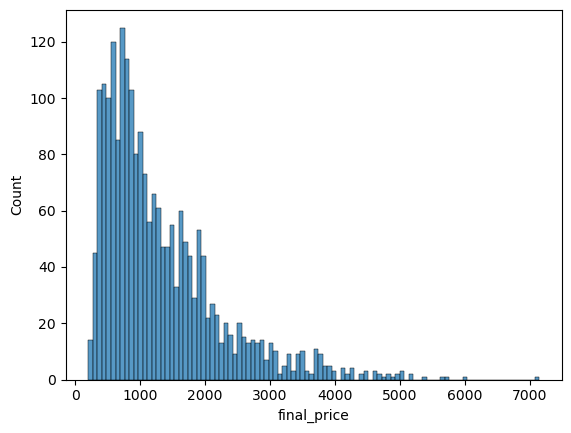

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df_base.final_price, bins=100)

<Axes: xlabel='final_price', ylabel='Count'>

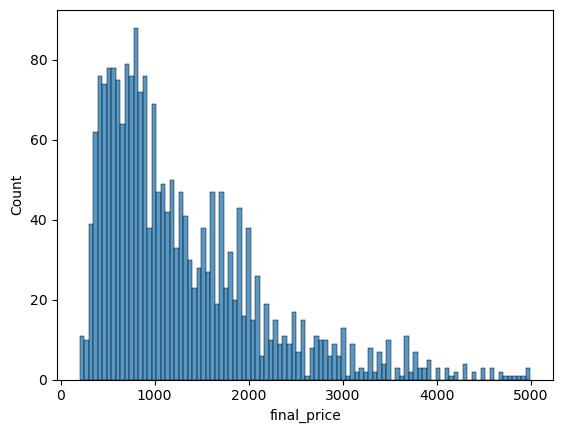

In [51]:
sns.histplot(df_base.final_price[df_base.final_price < 5000], bins = 100)

**Check for missing values**

In [52]:
df_base.isnull().any()

ram            False
storage        False
screen          True
final_price    False
dtype: bool

In [53]:
df_base.isnull().sum()


ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [54]:
df_base['ram'].median()

16.0

**Split the dataset**

In [55]:
n = len(df_base)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [56]:
n_val, n_test, n_train

(432, 432, 1296)

In [57]:
import numpy as np

idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

In [58]:
df_train = df_base.iloc[idx[:n_train]]
df_val = df_base.iloc[idx[n_train:n_train+n_val]]
df_test = df_base.iloc[idx[n_train+n_val:]]

In [59]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [60]:
#y_train = np.log1p(df_train.final_price.values)
#y_val = np.log1p(df_val.final_price.values)
#y_test = np.log1p(df_test.final_price.values)

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values


In [61]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

**Option 1: Fill missing values with 0**

In [62]:
X_train_null = df_train.fillna(0).values

In [63]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [64]:
w0, w = train_linear_regression(X_train_null, y_train)

In [65]:
w0, w

(676.8954853003158, array([ 43.70681555,   0.86506867, -36.10399833]))

In [66]:
y_pred_null = w0 + X_train_null.dot(w)

<Axes: ylabel='Count'>

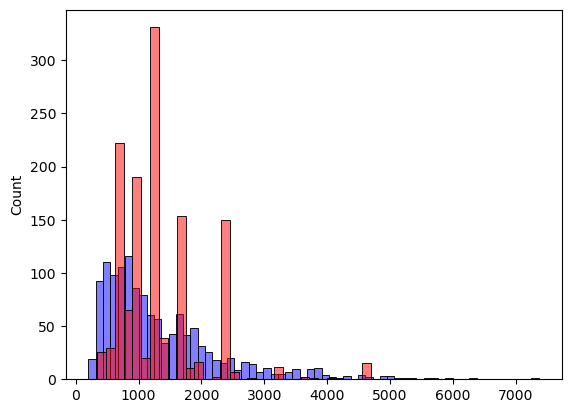

In [67]:
sns.histplot(y_train, color='blue', alpha = 0.5, bins = 50)
sns.histplot(y_pred_null, color='red', alpha = 0.5, bins = 50)


**Option 2: Fill missing values with mean**

In [68]:
mean_value = df_train['screen'].mean()
mean_value

15.163534416086618

In [69]:
df_train.isnull().any()

ram        False
storage    False
screen      True
dtype: bool

In [70]:
X_train_mean = df_train.fillna(mean_value)

In [71]:
X_train_mean.isnull().any()


ram        False
storage    False
screen     False
dtype: bool

In [72]:
w0, w = train_linear_regression(X_train_mean, y_train)
w0, w

(808.9159907332298, array([ 43.90774584,   0.87135236, -45.18273312]))

In [73]:
y_pred_mean = w0 + X_train_mean.dot(w)

<Axes: ylabel='Count'>

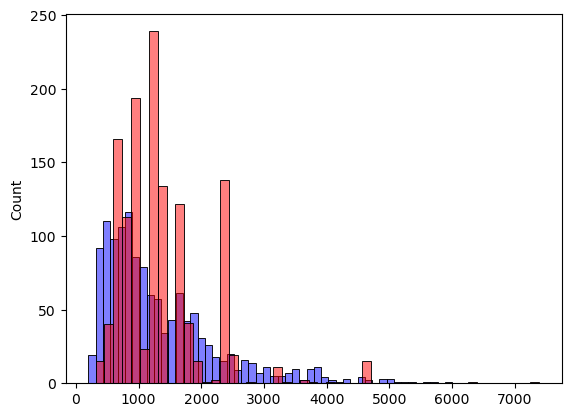

In [74]:
sns.histplot(y_train, color='blue', alpha = 0.5, bins = 50)
sns.histplot(y_pred_mean, color='red', alpha = 0.5, bins = 50)

**Compare with RSME**

In [75]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [76]:
rmse_null = rmse(y_train, y_pred_null)
round(rmse_null,2)

602.39

In [77]:
rmse_mean = rmse(y_train, y_pred_mean)
round(rmse_mean, 2)

602.18

**Regularized Linear Regression**


In [78]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [79]:
def prepare_X(df):
    df = df.fillna(0)
    X = df.values
    return X

In [80]:
R = [0, 0.01, 0.1, 1, 5, 10, 100]

In [81]:
for r in R:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train_null, y_train, r)
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    rmse_value = rmse(y_val, y_pred)
    print(f'RMSE for {r}: {round(rmse_value,2)}')


RMSE for 0: 597.36
RMSE for 0.01: 597.36
RMSE for 0.1: 597.35
RMSE for 1: 597.21
RMSE for 5: 597.01
RMSE for 10: 597.06
RMSE for 100: 597.9


**Different Seeds**

In [82]:
S = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [83]:
del df_train, df_val, df_test, y_train, y_val, y_test


In [84]:
all_scores = []

for s in S:

    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_train = df_base.iloc[idx[:n_train]]
    df_val = df_base.iloc[idx[n_train:n_train+n_val]]
    df_test = df_base.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    #y_train = np.log1p(df_train.final_price.values)
    #y_val = np.log1p(df_val.final_price.values)
    #y_test = np.log1p(df_test.final_price.values)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    rmse_value = rmse(y_val, y_pred)
    print(f'RSME for seed {s}: {round(rmse_value,2)}')
    all_scores.append(rmse_value)

std = np.std(all_scores)
round(std, 3)


RSME for seed 0: 565.45
RSME for seed 1: 636.8
RSME for seed 2: 588.96
RSME for seed 3: 597.81
RSME for seed 4: 571.96
RSME for seed 5: 573.24
RSME for seed 6: 647.34
RSME for seed 7: 550.44
RSME for seed 8: 587.33
RSME for seed 9: 576.1


29.176

**Question 6**

In [85]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df_base.iloc[idx[:n_train]]
df_val = df_base.iloc[idx[n_train:n_train+n_val]]
df_test = df_base.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#y_train = np.log1p(df_train.final_price.values)
#y_val = np.log1p(df_val.final_price.values)
#y_test = np.log1p(df_test.final_price.values)

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

X_train = prepare_X(df_train)
X_val = prepare_X(df_val)
X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)
w0, w = train_linear_regression_reg(X_combined, y_combined, r = 0.001)

X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
rmse_value = rmse(y_test, y_pred)
print(f'RSME for seed {s}: {round(rmse_value,2)}')

RSME for seed 9: 608.61
